Classification Algorithms Comparison


This module implements and compares k-NN, Decision Tree, and Neural Network classifiers
on the IRIS dataset with comprehensive analysis and visualization.

Date: 2025


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_curve, auc)
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from scipy import stats
from typing import Dict, List, Tuple, Any
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')


In [7]:
@dataclass
class ClassifierResults:
    """Data class to store classifier results and metrics."""
    name: str
    accuracy: float
    precision: float
    recall: float
    f1: float
    confusion_matrix: np.ndarray
    predictions: np.ndarray
    probabilities: np.ndarray
    cv_scores: np.ndarray
    training_time: float
    prediction_time: float
    hyperparameters: Dict[str, Any]


In [8]:
class ClassificationComparison:
    """
    Comprehensive classification algorithm comparison framework.

    Implements k-NN, Decision Tree, and Neural Network classifiers with
    extensive analysis, visualization, and statistical testing.
    """

    def __init__(self, test_size: float = 0.3, random_state: int = 42, cv_folds: int = 5):
        """
        Initialize the classification comparison framework.

        Args:
            test_size: Proportion of dataset for testing
            random_state: Random seed for reproducible results
            cv_folds: Number of cross-validation folds
        """
        self.test_size = test_size
        self.random_state = random_state
        self.cv_folds = cv_folds
        self.results = {}
        self.feature_names = None
        self.target_names = None

        # Load and prepare data
        self._load_data()

    def _load_data(self):
        """Load and prepare the IRIS dataset."""
        iris = load_iris()
        self.X = iris.data
        self.y = iris.target
        self.feature_names = iris.feature_names
        self.target_names = iris.target_names

        # Create DataFrame for easier manipulation
        self.df = pd.DataFrame(self.X, columns=self.feature_names)
        self.df['target'] = self.y
        self.df['species'] = [self.target_names[i] for i in self.y]

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_state,
            stratify=self.y
        )

        # Scale features for neural network
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        print(f"Dataset loaded: {self.X.shape[0]} samples, {self.X.shape[1]} features")
        print(f"Training set: {self.X_train.shape[0]} samples")
        print(f"Test set: {self.X_test.shape[0]} samples")

    def perform_feature_analysis(self) -> Dict[str, Any]:
        """
        Perform comprehensive feature analysis and selection.

        Returns:
            Dictionary containing feature analysis results
        """
        print("\nPerforming Feature Analysis...")

        analysis = {}

        # Correlation analysis
        correlation_matrix = self.df[self.feature_names].corr()
        analysis['correlation_matrix'] = correlation_matrix

        # Univariate feature selection using ANOVA F-test
        selector_f = SelectKBest(score_func=f_classif, k='all')
        selector_f.fit(self.X_train, self.y_train)
        f_scores = selector_f.scores_
        f_pvalues = selector_f.pvalues_

        # Mutual information feature selection
        selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
        selector_mi.fit(self.X_train, self.y_train)
        mi_scores = selector_mi.scores_

        # Feature importance DataFrame
        feature_importance_df = pd.DataFrame({
            'Feature': self.feature_names,
            'F_Score': f_scores,
            'F_PValue': f_pvalues,
            'Mutual_Info': mi_scores
        })
        feature_importance_df = feature_importance_df.sort_values('F_Score', ascending=False)
        analysis['feature_importance'] = feature_importance_df

        # Statistical summary
        analysis['statistical_summary'] = self.df.groupby('species')[self.feature_names].describe()

        return analysis

    def train_knn_classifier(self) -> ClassifierResults:
        """
        Train and evaluate k-NN classifier with hyperparameter tuning.

        Returns:
            ClassifierResults object containing all metrics
        """
        print("\nTraining k-NN Classifier...")

        # Hyperparameter tuning
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }

        knn = KNeighborsClassifier()
        grid_search = GridSearchCV(knn, param_grid, cv=self.cv_folds,
                                 scoring='accuracy', n_jobs=-1)

        import time
        start_time = time.time()
        grid_search.fit(self.X_train, self.y_train)
        training_time = time.time() - start_time

        best_knn = grid_search.best_estimator_

        # Make predictions
        start_time = time.time()
        y_pred = best_knn.predict(self.X_test)
        y_proba = best_knn.predict_proba(self.X_test)
        prediction_time = time.time() - start_time

        # Cross-validation scores
        cv_scores = cross_val_score(best_knn, self.X_train, self.y_train,
                                  cv=self.cv_folds, scoring='accuracy')

        # Calculate metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred, average='weighted')
        recall = recall_score(self.y_test, y_pred, average='weighted')
        f1 = f1_score(self.y_test, y_pred, average='weighted')
        cm = confusion_matrix(self.y_test, y_pred)

        return ClassifierResults(
            name='k-NN',
            accuracy=accuracy,
            precision=precision,
            recall=recall,
            f1=f1,
            confusion_matrix=cm,
            predictions=y_pred,
            probabilities=y_proba,
            cv_scores=cv_scores,
            training_time=training_time,
            prediction_time=prediction_time,
            hyperparameters=grid_search.best_params_
        )

    def train_decision_tree_classifier(self) -> ClassifierResults:
        """
        Train and evaluate Decision Tree classifier with hyperparameter tuning.

        Returns:
            ClassifierResults object containing all metrics
        """
        print("\nTraining Decision Tree Classifier...")

        # Hyperparameter tuning
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 3, 5, 7, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

        dt = DecisionTreeClassifier(random_state=self.random_state)
        grid_search = GridSearchCV(dt, param_grid, cv=self.cv_folds,
                                 scoring='accuracy', n_jobs=-1)

        import time
        start_time = time.time()
        grid_search.fit(self.X_train, self.y_train)
        training_time = time.time() - start_time

        best_dt = grid_search.best_estimator_

        # Make predictions
        start_time = time.time()
        y_pred = best_dt.predict(self.X_test)
        y_proba = best_dt.predict_proba(self.X_test)
        prediction_time = time.time() - start_time

        # Cross-validation scores
        cv_scores = cross_val_score(best_dt, self.X_train, self.y_train,
                                  cv=self.cv_folds, scoring='accuracy')

        # Calculate metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred, average='weighted')
        recall = recall_score(self.y_test, y_pred, average='weighted')
        f1 = f1_score(self.y_test, y_pred, average='weighted')
        cm = confusion_matrix(self.y_test, y_pred)

        # Store the trained model for visualization
        self.best_decision_tree = best_dt

        return ClassifierResults(
            name='Decision Tree',
            accuracy=accuracy,
            precision=precision,
            recall=recall,
            f1=f1,
            confusion_matrix=cm,
            predictions=y_pred,
            probabilities=y_proba,
            cv_scores=cv_scores,
            training_time=training_time,
            prediction_time=prediction_time,
            hyperparameters=grid_search.best_params_
        )

    def train_neural_network_classifier(self) -> ClassifierResults:
        """
        Train and evaluate Neural Network classifier with architecture search.

        Returns:
            ClassifierResults object containing all metrics
        """
        print("\nTraining Neural Network Classifier...")

        # Hyperparameter tuning for different architectures
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50), (100, 50, 25)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [1000]
        }

        mlp = MLPClassifier(random_state=self.random_state, early_stopping=True,
                           validation_fraction=0.1)
        grid_search = GridSearchCV(mlp, param_grid, cv=self.cv_folds,
                                 scoring='accuracy', n_jobs=-1)

        import time
        start_time = time.time()
        grid_search.fit(self.X_train_scaled, self.y_train)  # Use scaled features
        training_time = time.time() - start_time

        best_mlp = grid_search.best_estimator_

        # Make predictions
        start_time = time.time()
        y_pred = best_mlp.predict(self.X_test_scaled)
        y_proba = best_mlp.predict_proba(self.X_test_scaled)
        prediction_time = time.time() - start_time

        # Cross-validation scores (using scaled features)
        cv_scores = cross_val_score(best_mlp, self.X_train_scaled, self.y_train,
                                  cv=self.cv_folds, scoring='accuracy')

        # Calculate metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred, average='weighted')
        recall = recall_score(self.y_test, y_pred, average='weighted')
        f1 = f1_score(self.y_test, y_pred, average='weighted')
        cm = confusion_matrix(self.y_test, y_pred)

        # Store the trained model and add training details
        self.best_neural_network = best_mlp
        hyperparams = grid_search.best_params_.copy()
        hyperparams['n_iter'] = best_mlp.n_iter_
        hyperparams['loss'] = best_mlp.loss_

        return ClassifierResults(
            name='Neural Network',
            accuracy=accuracy,
            precision=precision,
            recall=recall,
            f1=f1,
            confusion_matrix=cm,
            predictions=y_pred,
            probabilities=y_proba,
            cv_scores=cv_scores,
            training_time=training_time,
            prediction_time=prediction_time,
            hyperparameters=hyperparams
        )

    def run_all_classifiers(self) -> Dict[str, ClassifierResults]:
        """
        Run all classifiers and return results.

        Returns:
            Dictionary mapping classifier names to their results
        """
        print("Running All Classifiers...")
        print("=" * 40)

        # Train all classifiers
        self.results['k-NN'] = self.train_knn_classifier()
        self.results['Decision Tree'] = self.train_decision_tree_classifier()
        self.results['Neural Network'] = self.train_neural_network_classifier()

        return self.results

    def perform_statistical_analysis(self) -> Dict[str, Any]:
        """
        Perform statistical significance testing between classifiers.

        Returns:
            Dictionary containing statistical analysis results
        """
        print("\nPerforming Statistical Analysis...")

        analysis = {}

        # Extract CV scores for each classifier
        cv_scores = {}
        for name, result in self.results.items():
            cv_scores[name] = result.cv_scores

        # Perform pairwise t-tests
        classifiers = list(cv_scores.keys())
        p_values = np.zeros((len(classifiers), len(classifiers)))

        for i, clf1 in enumerate(classifiers):
            for j, clf2 in enumerate(classifiers):
                if i != j:
                    t_stat, p_val = stats.ttest_rel(cv_scores[clf1], cv_scores[clf2])
                    p_values[i, j] = p_val
                else:
                    p_values[i, j] = 1.0

        analysis['pairwise_ttest'] = pd.DataFrame(p_values,
                                                index=classifiers,
                                                columns=classifiers)

        # ANOVA test
        f_stat, p_val = stats.f_oneway(*cv_scores.values())
        analysis['anova'] = {'f_statistic': f_stat, 'p_value': p_val}

        # Effect sizes (Cohen's d)
        effect_sizes = np.zeros((len(classifiers), len(classifiers)))
        for i, clf1 in enumerate(classifiers):
            for j, clf2 in enumerate(classifiers):
                if i != j:
                    scores1, scores2 = cv_scores[clf1], cv_scores[clf2]
                    pooled_std = np.sqrt(((len(scores1) - 1) * np.var(scores1, ddof=1) +
                                        (len(scores2) - 1) * np.var(scores2, ddof=1)) /
                                       (len(scores1) + len(scores2) - 2))
                    effect_size = (np.mean(scores1) - np.mean(scores2)) / pooled_std
                    effect_sizes[i, j] = effect_size

        analysis['effect_sizes'] = pd.DataFrame(effect_sizes,
                                              index=classifiers,
                                              columns=classifiers)

        return analysis

    def create_comprehensive_visualizations(self, feature_analysis: Dict) -> List[plt.Figure]:
        """
        Create comprehensive visualizations for the analysis.

        Args:
            feature_analysis: Results from feature analysis

        Returns:
            List of matplotlib Figure objects
        """
        figures = []

        # Set style
        plt.style.use('default')
        sns.set_palette("husl")

        # 1. Dataset Exploration
        fig1, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Pairplot-style scatter plots
        features_to_plot = [0, 1, 2, 3]  # All features
        for i, ax in enumerate(axes.flat):
            if i < len(features_to_plot):
                feat_idx = features_to_plot[i]
                for j, species in enumerate(self.target_names):
                    mask = self.df['species'] == species
                    ax.scatter(self.df.loc[mask, self.feature_names[feat_idx]],
                             self.df.loc[mask, self.feature_names[(feat_idx + 1) % 4]],
                             label=species, alpha=0.7)
                ax.set_xlabel(self.feature_names[feat_idx])
                ax.set_ylabel(self.feature_names[(feat_idx + 1) % 4])
                ax.legend()
                ax.grid(True, alpha=0.3)

        fig1.suptitle('IRIS Dataset Feature Relationships', fontsize=16)
        plt.tight_layout()
        figures.append(fig1)

        # 2. Feature Importance Analysis
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # ANOVA F-scores
        feature_imp = feature_analysis['feature_importance']
        bars1 = ax1.bar(feature_imp['Feature'], feature_imp['F_Score'], color='skyblue')
        ax1.set_title('Feature Importance (ANOVA F-Score)')
        ax1.set_ylabel('F-Score')
        ax1.tick_params(axis='x', rotation=45)

        # Add value labels
        for bar, value in zip(bars1, feature_imp['F_Score']):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.2f}', ha='center', va='bottom')

        # Mutual Information scores
        bars2 = ax2.bar(feature_imp['Feature'], feature_imp['Mutual_Info'], color='lightcoral')
        ax2.set_title('Feature Importance (Mutual Information)')
        ax2.set_ylabel('Mutual Information Score')
        ax2.tick_params(axis='x', rotation=45)

        # Add value labels
        for bar, value in zip(bars2, feature_imp['Mutual_Info']):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        figures.append(fig2)

        # 3. Correlation Heatmap
        fig3, ax = plt.subplots(figsize=(10, 8))
        correlation_matrix = feature_analysis['correlation_matrix']
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
                   center=0, square=True, ax=ax, cbar_kws={'shrink': 0.8})
        ax.set_title('Feature Correlation Matrix', fontsize=14)
        plt.tight_layout()
        figures.append(fig3)

        # 4. Classifier Performance Comparison
        fig4, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Accuracy comparison
        classifiers = list(self.results.keys())
        accuracies = [self.results[clf].accuracy for clf in classifiers]

        bars = axes[0, 0].bar(classifiers, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[0, 0].set_title('Accuracy Comparison')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_ylim(0, 1)

        # Add value labels
        for bar, value in zip(bars, accuracies):
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{value:.3f}', ha='center', va='bottom')

        # F1-Score comparison
        f1_scores = [self.results[clf].f1 for clf in classifiers]
        bars = axes[0, 1].bar(classifiers, f1_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[0, 1].set_title('F1-Score Comparison')
        axes[0, 1].set_ylabel('F1-Score')
        axes[0, 1].set_ylim(0, 1)

        for bar, value in zip(bars, f1_scores):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{value:.3f}', ha='center', va='bottom')

        # Training time comparison
        train_times = [self.results[clf].training_time for clf in classifiers]
        bars = axes[1, 0].bar(classifiers, train_times, color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[1, 0].set_title('Training Time Comparison')
        axes[1, 0].set_ylabel('Training Time (seconds)')

        for bar, value in zip(bars, train_times):
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                           f'{value:.3f}s', ha='center', va='bottom')

        # Cross-validation scores boxplot
        cv_data = [self.results[clf].cv_scores for clf in classifiers]
        box_plot = axes[1, 1].boxplot(cv_data, labels=classifiers, patch_artist=True)
        colors = ['skyblue', 'lightcoral', 'lightgreen']
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)

        axes[1, 1].set_title('Cross-Validation Score Distribution')
        axes[1, 1].set_ylabel('CV Accuracy')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        figures.append(fig4)

        # 5. Confusion Matrices
        fig5, axes = plt.subplots(1, 3, figsize=(18, 5))

        for i, (clf_name, result) in enumerate(self.results.items()):
            sns.heatmap(result.confusion_matrix, annot=True, fmt='d',
                       xticklabels=self.target_names, yticklabels=self.target_names,
                       ax=axes[i], cmap='Blues')
            axes[i].set_title(f'{clf_name}\nAccuracy: {result.accuracy:.3f}')
            axes[i].set_ylabel('True Label')
            axes[i].set_xlabel('Predicted Label')

        plt.tight_layout()
        figures.append(fig5)

        # 6. ROC Curves (Multi-class)
        fig6, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Binarize labels for ROC analysis
        lb = LabelBinarizer()
        y_test_binary = lb.fit_transform(self.y_test)

        for i, (clf_name, result) in enumerate(self.results.items()):
            ax = axes[i]
            y_proba = result.probabilities

            # Plot ROC for each class
            for j in range(len(self.target_names)):
                if y_test_binary.shape[1] > 1:  # Multi-class case
                    fpr, tpr, _ = roc_curve(y_test_binary[:, j], y_proba[:, j])
                else:  # Binary case (shouldn't happen with IRIS)
                    fpr, tpr, _ = roc_curve(self.y_test == j, y_proba[:, j])

                roc_auc = auc(fpr, tpr)
                ax.plot(fpr, tpr, label=f'{self.target_names[j]} (AUC = {roc_auc:.2f})')

            ax.plot([0, 1], [0, 1], 'k--', alpha=0.6)
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC Curves - {clf_name}')
            ax.legend()
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        figures.append(fig6)

        # 7. Decision Tree Visualization (if available)
        if hasattr(self, 'best_decision_tree'):
            fig7, ax = plt.subplots(figsize=(20, 12))
            plot_tree(self.best_decision_tree, feature_names=self.feature_names,
                     class_names=self.target_names, filled=True, rounded=True,
                     fontsize=10, ax=ax)
            ax.set_title('Decision Tree Structure', fontsize=16)
            figures.append(fig7)

        return figures

    def generate_comprehensive_report(self, feature_analysis: Dict,
                                    statistical_analysis: Dict) -> str:
        """
        Generate a comprehensive analysis report.

        Args:
            feature_analysis: Results from feature analysis
            statistical_analysis: Results from statistical analysis

        Returns:
            Formatted report string
        """
        report = []
        report.append("CLASSIFICATION ALGORITHMS COMPARISON REPORT")
        report.append("=" * 60)
        report.append(f"Dataset: IRIS (150 samples, 4 features, 3 classes)")
        report.append(f"Train/Test Split: {100*(1-self.test_size):.0f}%/{100*self.test_size:.0f}%")
        report.append(f"Cross-Validation: {self.cv_folds}-fold")
        report.append("")

        # Dataset Summary
        report.append("DATASET SUMMARY")
        report.append("-" * 20)
        for i, species in enumerate(self.target_names):
            count = np.sum(self.y == i)
            report.append(f"• {species}: {count} samples ({100*count/len(self.y):.1f}%)")
        report.append("")

        # Feature Analysis
        report.append("FEATURE ANALYSIS")
        report.append("-" * 18)
        feature_imp = feature_analysis['feature_importance']
        report.append("Feature Importance (ANOVA F-Score):")
        for _, row in feature_imp.iterrows():
            report.append(f"  • {row['Feature']}: {row['F_Score']:.2f} (p={row['F_PValue']:.4f})")
        report.append("")

        # Model Performance
        report.append("MODEL PERFORMANCE COMPARISON")
        report.append("-" * 32)

        # Performance table
        performance_data = []
        for clf_name, result in self.results.items():
            performance_data.append([
                clf_name,
                f"{result.accuracy:.4f}",
                f"{result.precision:.4f}",
                f"{result.recall:.4f}",
                f"{result.f1:.4f}",
                f"{np.mean(result.cv_scores):.4f} ± {np.std(result.cv_scores):.4f}",
                f"{result.training_time:.4f}",
                f"{result.prediction_time:.6f}"
            ])

        headers = ["Classifier", "Accuracy", "Precision", "Recall", "F1-Score",
                  "CV Score (Mean ± Std)", "Train Time (s)", "Pred Time (s)"]

        # Create formatted table
        col_widths = [max(len(str(row[i])) for row in [headers] + performance_data)
                     for i in range(len(headers))]

        # Header
        header_line = " | ".join(f"{headers[i]:<{col_widths[i]}}" for i in range(len(headers)))
        report.append(header_line)
        report.append("-" * len(header_line))

        # Data rows
        for row in performance_data:
            data_line = " | ".join(f"{row[i]:<{col_widths[i]}}" for i in range(len(row)))
            report.append(data_line)

        report.append("")

        # Hyperparameters
        report.append("OPTIMAL HYPERPARAMETERS")
        report.append("-" * 26)
        for clf_name, result in self.results.items():
            report.append(f"{clf_name}:")
            for param, value in result.hyperparameters.items():
                report.append(f"  • {param}: {value}")
            report.append("")

        # Statistical Analysis
        report.append("STATISTICAL SIGNIFICANCE ANALYSIS")
        report.append("-" * 36)

        anova_result = statistical_analysis['anova']
        report.append(f"ANOVA Test: F = {anova_result['f_statistic']:.4f}, p = {anova_result['p_value']:.4f}")

        if anova_result['p_value'] < 0.05:
            report.append("→ Significant difference between classifiers (p < 0.05)")
        else:
            report.append("→ No significant difference between classifiers (p ≥ 0.05)")

        report.append("\nPairwise t-test results (p-values):")
        pairwise_results = statistical_analysis['pairwise_ttest']

        # Format pairwise comparison table
        classifiers = list(pairwise_results.index)
        report.append(f"{'':>15} | " + " | ".join(f"{clf:>12}" for clf in classifiers))
        report.append("-" * (15 + 3 + 15 * len(classifiers)))

        for i, clf1 in enumerate(classifiers):
            row_values = []
            for j, clf2 in enumerate(classifiers):
                if i == j:
                    row_values.append("    -    ")
                else:
                    p_val = pairwise_results.iloc[i, j]
                    significance = "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                    row_values.append(f"{p_val:.4f}{significance:>2}")
            report.append(f"{clf1:>15} | " + " | ".join(f"{val:>12}" for val in row_values))

        report.append("\n* p < 0.05, ** p < 0.01")
        report.append("")

        # Key Findings
        report.append("KEY FINDINGS AND RECOMMENDATIONS")
        report.append("-" * 36)

        # Find best performer
        best_clf = max(self.results.keys(), key=lambda x: self.results[x].accuracy)
        best_acc = self.results[best_clf].accuracy

        report.append(f"• Best performing classifier: {best_clf} (Accuracy: {best_acc:.4f})")

        # Feature importance insights
        most_important_feature = feature_imp.iloc[0]['Feature']
        report.append(f"• Most discriminative feature: {most_important_feature}")

        # Complexity vs Performance trade-off
        fastest_clf = min(self.results.keys(), key=lambda x: self.results[x].training_time)
        report.append(f"• Fastest training: {fastest_clf} ({self.results[fastest_clf].training_time:.4f}s)")

        # Generalization analysis
        cv_means = {clf: np.mean(result.cv_scores) for clf, result in self.results.items()}
        most_stable = max(cv_means.keys(), key=lambda x: cv_means[x])
        report.append(f"• Most stable (CV): {most_stable} ({cv_means[most_stable]:.4f})")

        return "\n".join(report)

In [9]:
def main():
    """Main function to run the classification comparison analysis."""
    print("Classification Algorithms Comparison - AI Lab 2025")
    print("=" * 50)

    # Initialize comparison framework
    comparison = ClassificationComparison(test_size=0.3, random_state=42, cv_folds=5)

    # Perform feature analysis
    feature_analysis = comparison.perform_feature_analysis()

    # Run all classifiers
    results = comparison.run_all_classifiers()

    # Perform statistical analysis
    statistical_analysis = comparison.perform_statistical_analysis()

    # Generate comprehensive report
    report = comparison.generate_comprehensive_report(feature_analysis, statistical_analysis)
    print("\n" + report)

    # Create visualizations
    print("\nGenerating comprehensive visualizations...")
    figures = comparison.create_comprehensive_visualizations(feature_analysis)

    # Display detailed results for each classifier
    print("\nDETAILED CLASSIFICATION REPORTS")
    print("=" * 40)

    for clf_name, result in results.items():
        print(f"\n{clf_name.upper()} CLASSIFIER:")
        print("-" * (len(clf_name) + 12))
        print(classification_report(comparison.y_test, result.predictions,
                                  target_names=comparison.target_names))

    # Show plots
    plt.show()

    print("\nAnalysis complete! Check the generated plots and reports for detailed results.")

Classification Algorithms Comparison - AI Lab 2025
Dataset loaded: 150 samples, 4 features
Training set: 105 samples
Test set: 45 samples

Performing Feature Analysis...
Running All Classifiers...

Training k-NN Classifier...

Training Decision Tree Classifier...

Training Neural Network Classifier...

Performing Statistical Analysis...

CLASSIFICATION ALGORITHMS COMPARISON REPORT
Dataset: IRIS (150 samples, 4 features, 3 classes)
Train/Test Split: 70%/30%
Cross-Validation: 5-fold

DATASET SUMMARY
--------------------
• setosa: 50 samples (33.3%)
• versicolor: 50 samples (33.3%)
• virginica: 50 samples (33.3%)

FEATURE ANALYSIS
------------------
Feature Importance (ANOVA F-Score):
  • petal length (cm): 814.73 (p=0.0000)
  • petal width (cm): 791.35 (p=0.0000)
  • sepal length (cm): 95.76 (p=0.0000)
  • sepal width (cm): 33.06 (p=0.0000)

MODEL PERFORMANCE COMPARISON
--------------------------------
Classifier     | Accuracy | Precision | Recall | F1-Score | CV Score (Mean ± Std) | Tr

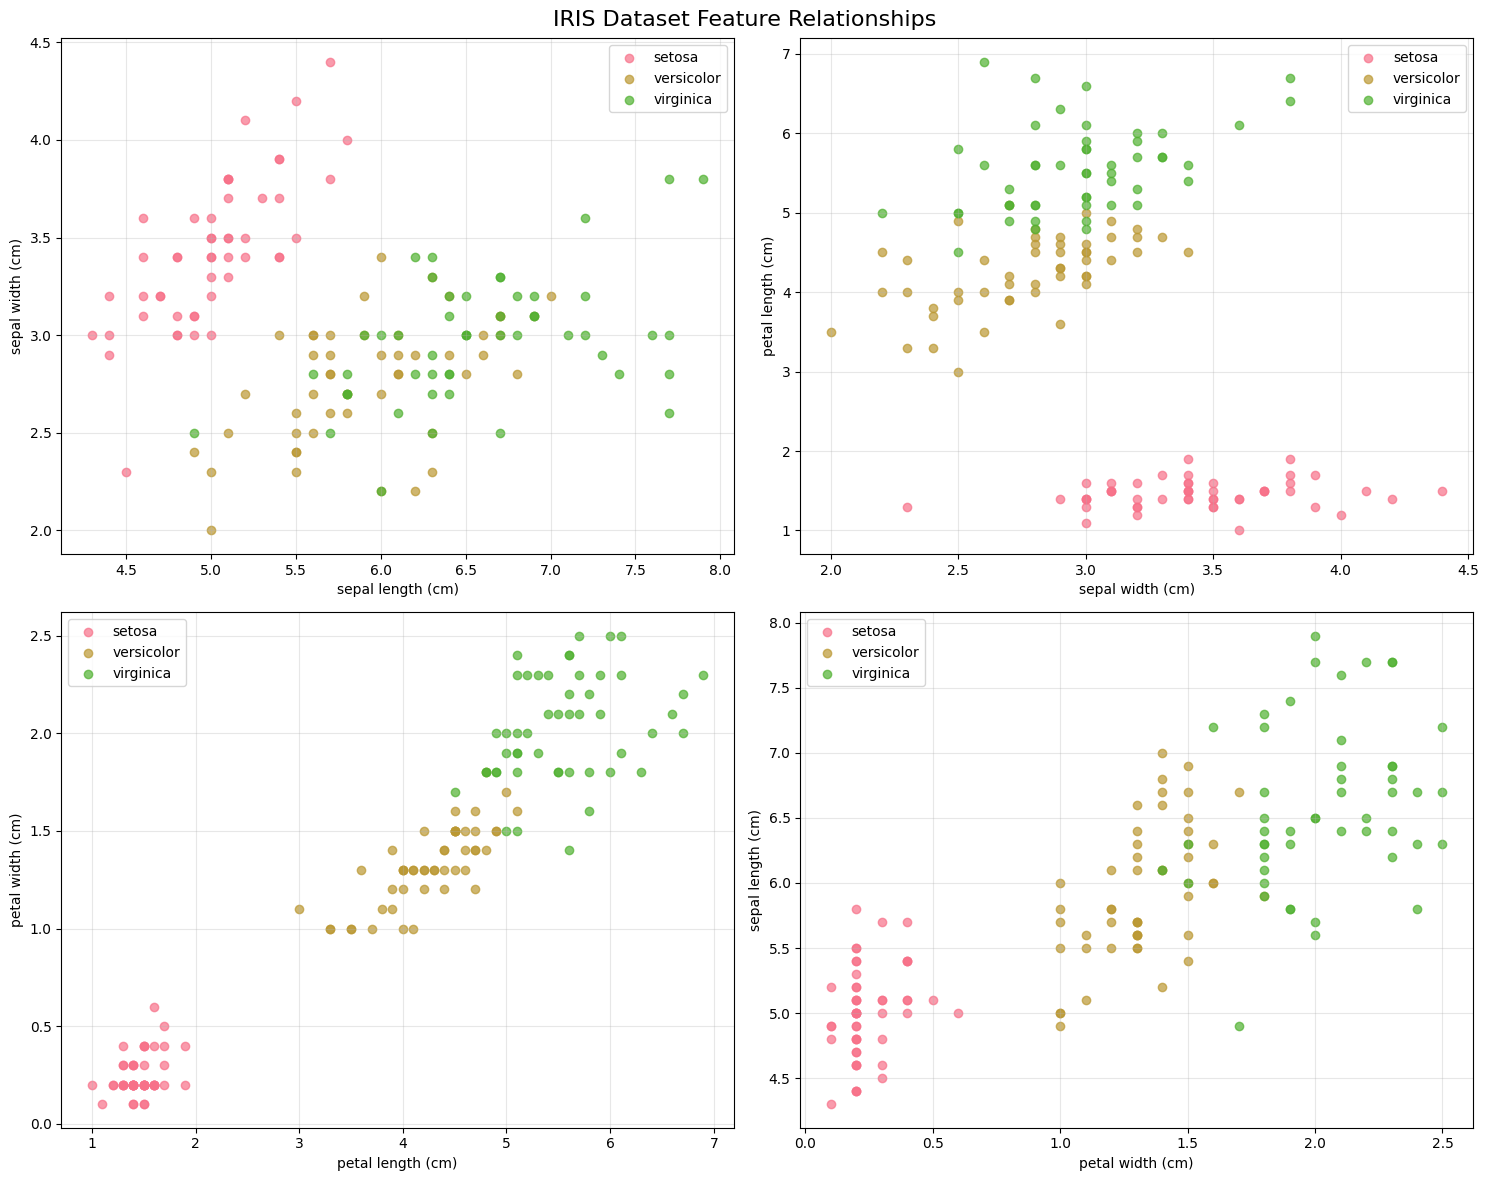

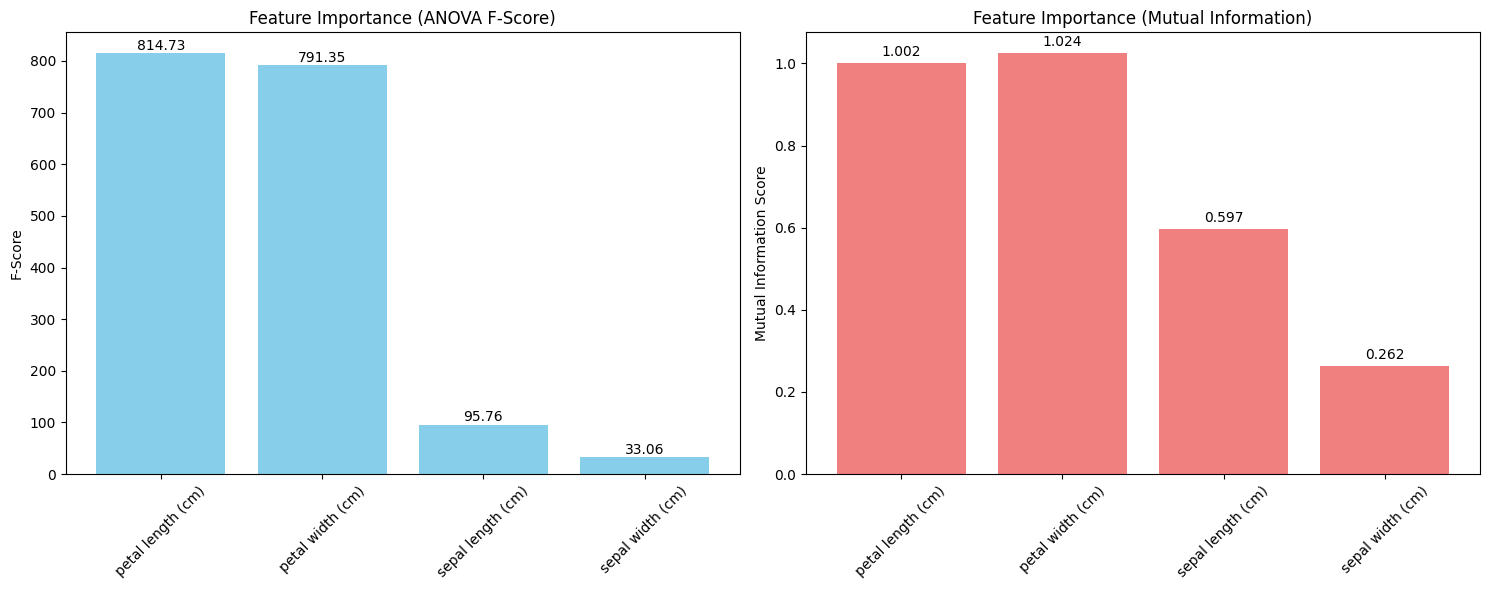

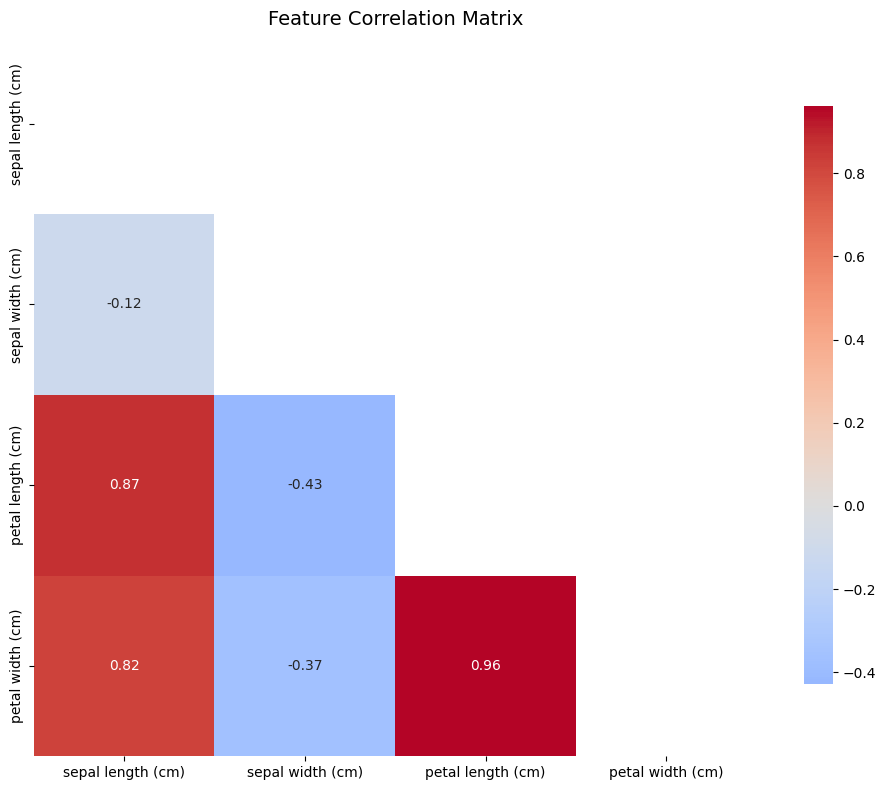

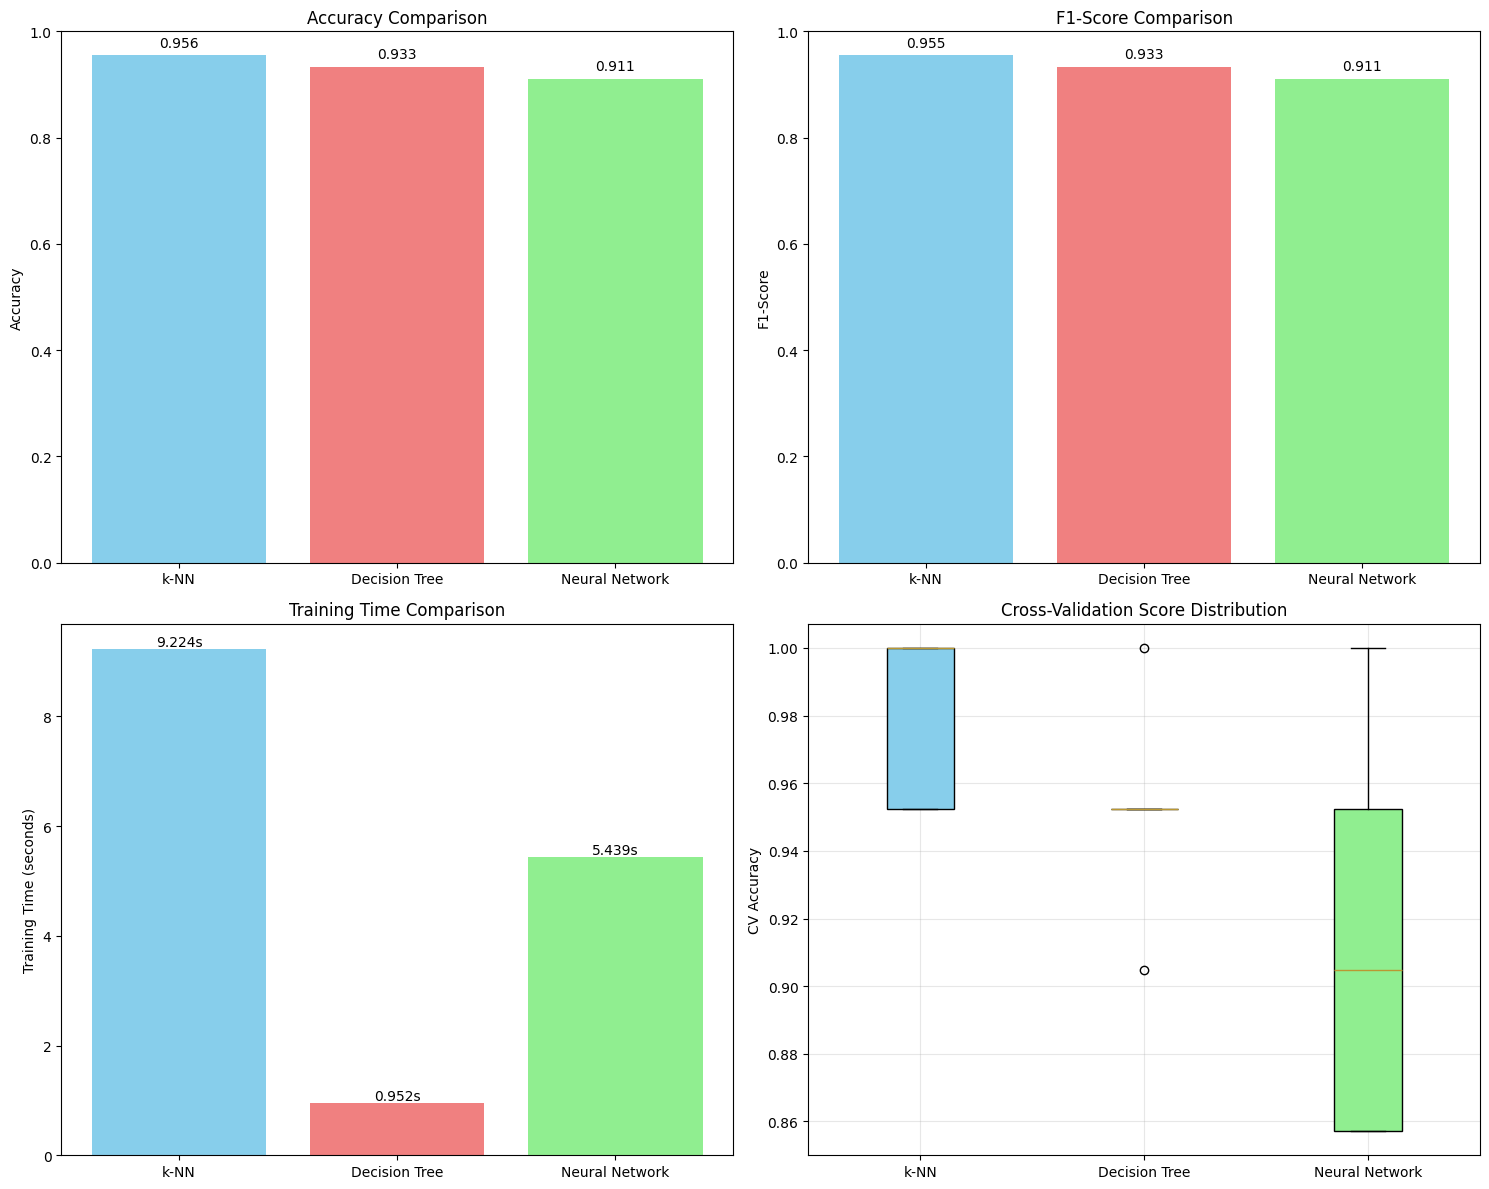

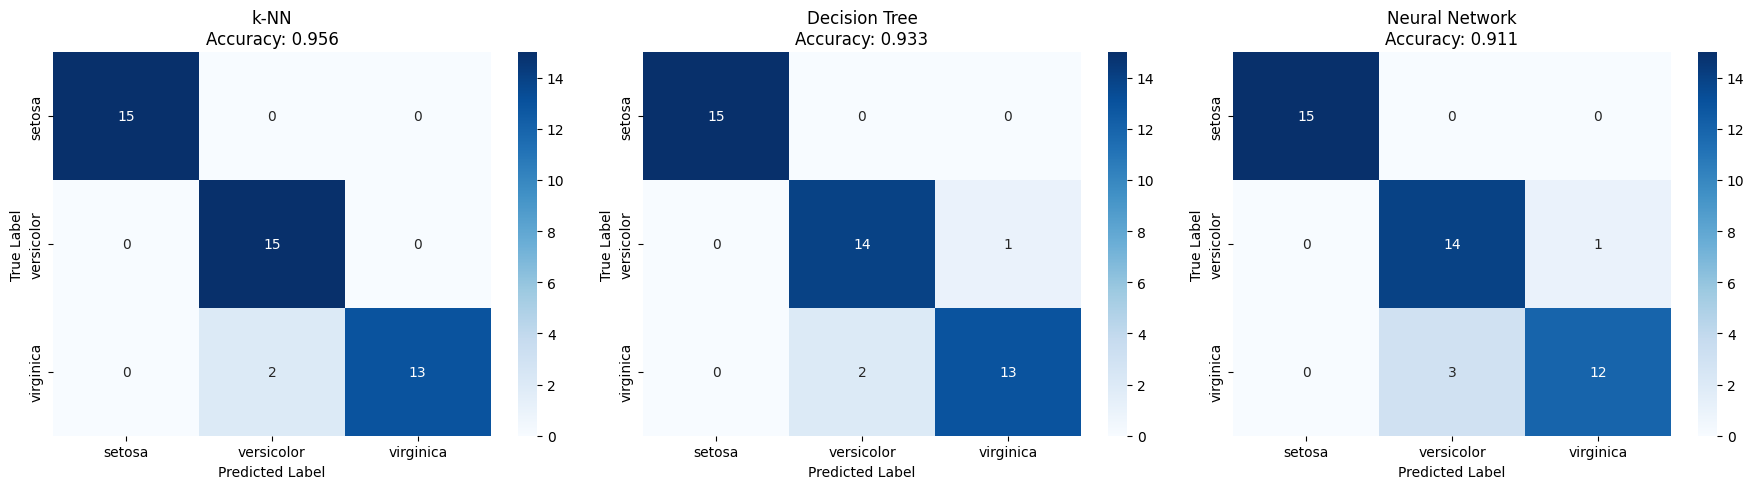

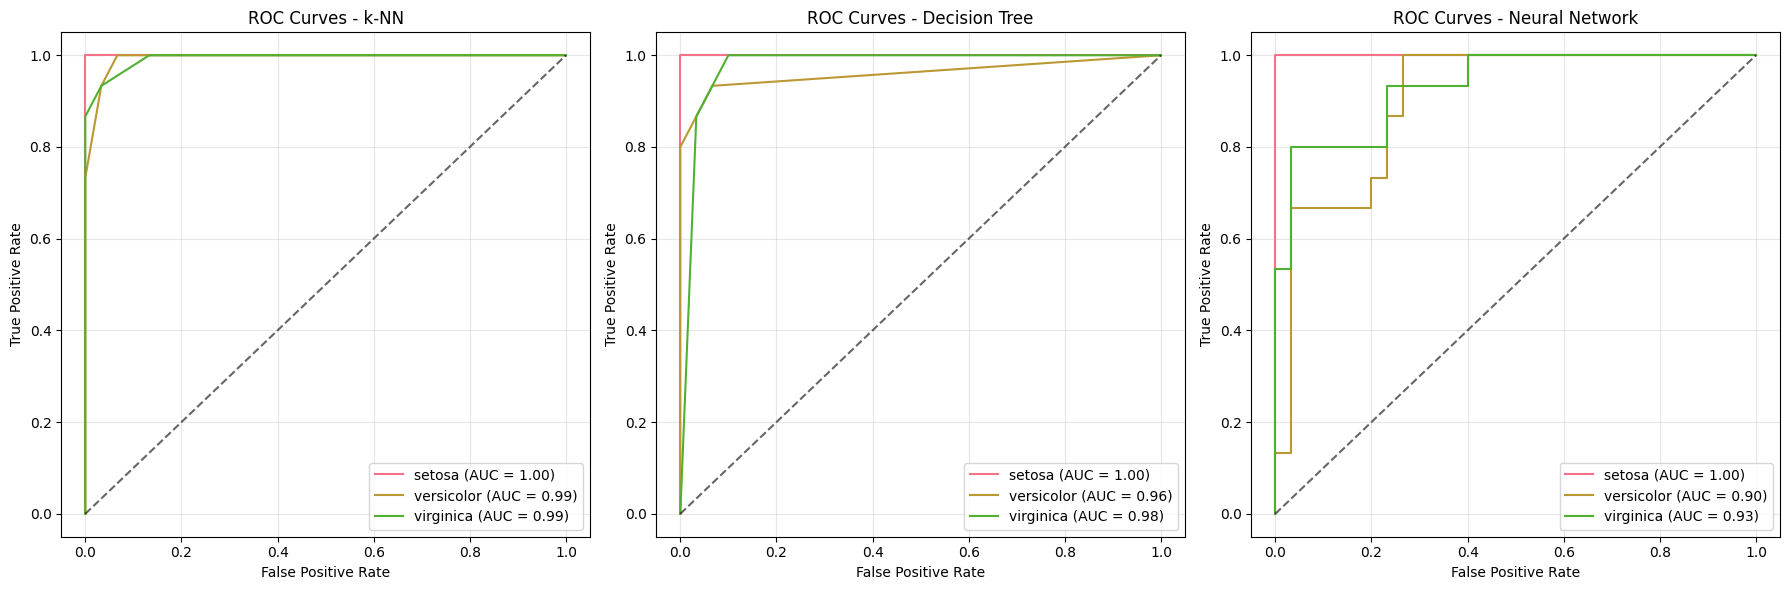

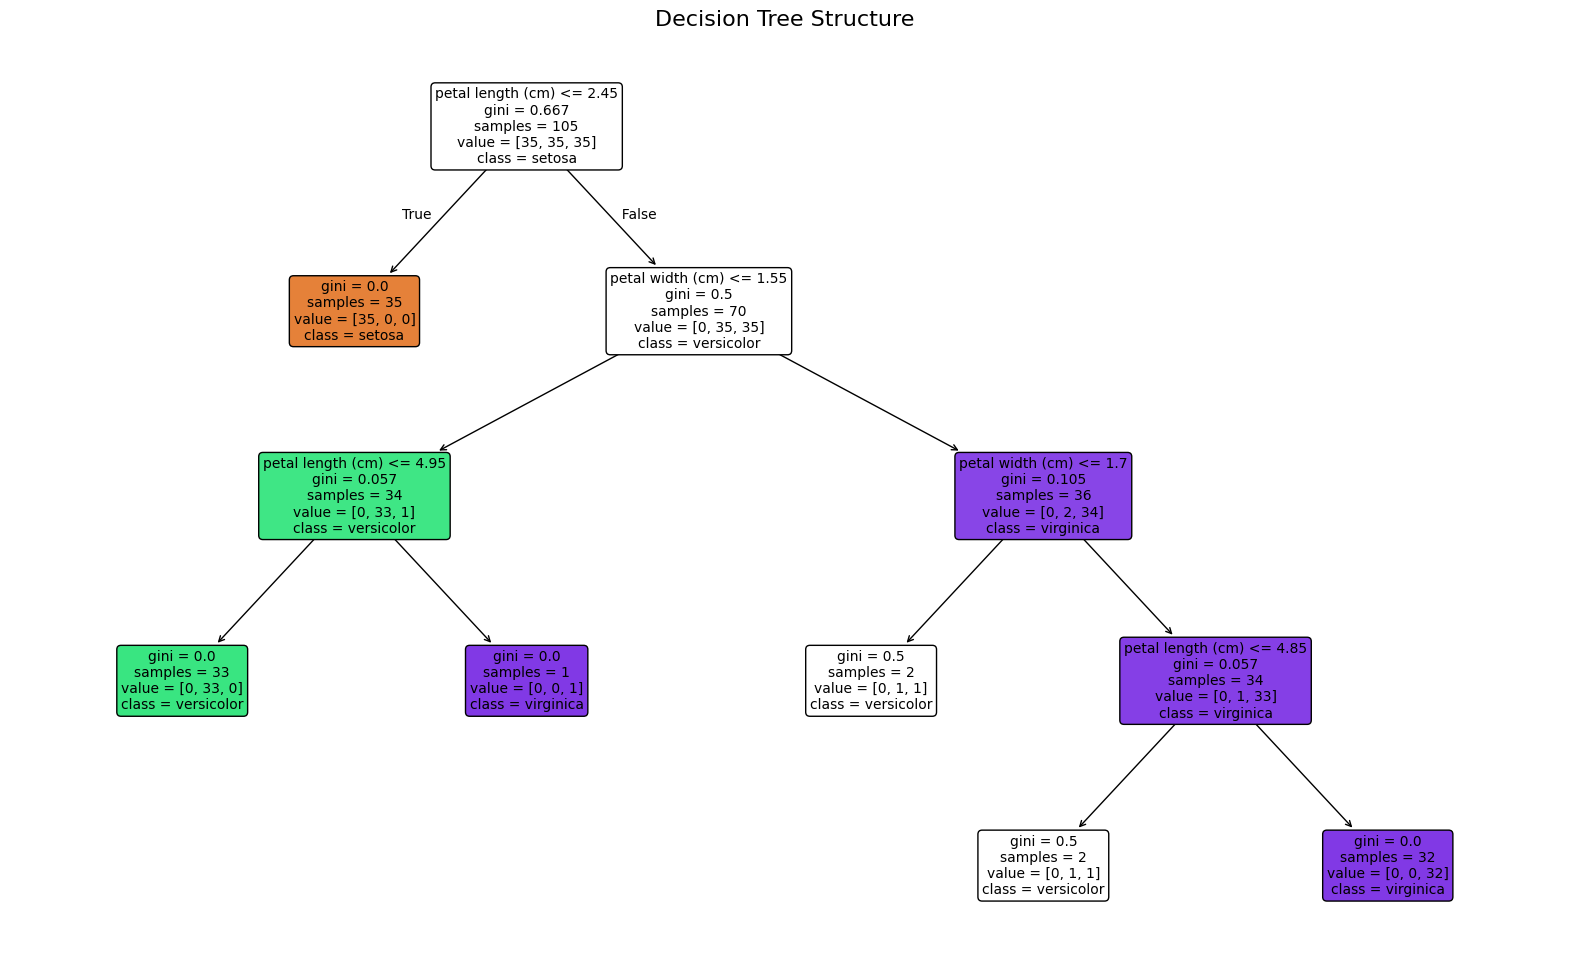


Analysis complete! Check the generated plots and reports for detailed results.


In [10]:
if __name__ == "__main__":
    main()